In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from semantic_selective_classification import semantic_binning

pd.set_option('future.no_silent_downcasting', True)

# path_results = Path(os.path.expandvars('$WORK/semantics/results/domains'))
path_results = Path(('../results/domains'))

c:\Users\Adrien\miniconda3\envs\alc\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
c:\Users\Adrien\miniconda3\envs\alc\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
attributes = ['viewpoint', 'weather', 'color', 'time', 'location']

path_res_file = path_results / 'results.csv'
if os.path.exists(path_res_file):
    df_res = pd.read_csv(path_res_file)
else:
    list_res = []
    for exp in ['20240308_1506_sideview', '20240306_1930_frontview', '20240308_1644_rearview']:
        df_exp = pd.read_csv(path_results / exp / 'results.csv')
        for _, row in df_exp.iterrows():
            probas_i = np.load(path_results / exp / str(row['id']) / 'probas.npy')
            labels_pred = ['dog' if probas_i[i, 0] > probas_i[i, 1] else 'other' for i in range(probas_i.shape[0])]
            list_res.append(pd.DataFrame({'confidence': probas_i.max(1), 'correct': (probas_i.argmax(1) == 0), 'prediction': labels_pred, 'ground_truth': 'dog', **row[attributes]}))
    df_res = pd.concat(list_res)
    df_res.to_csv(path_res_file)

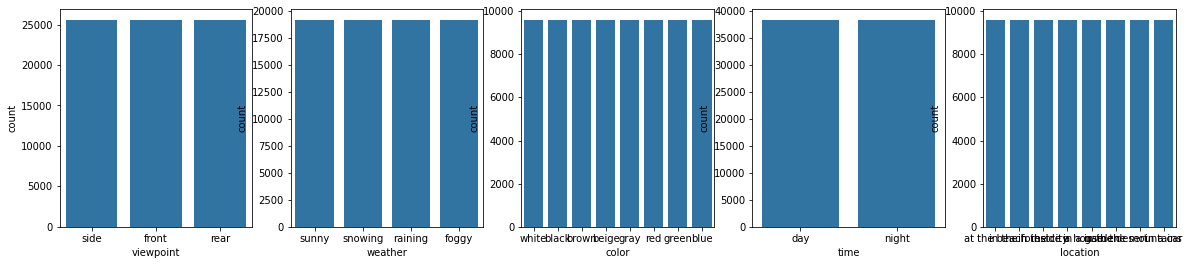

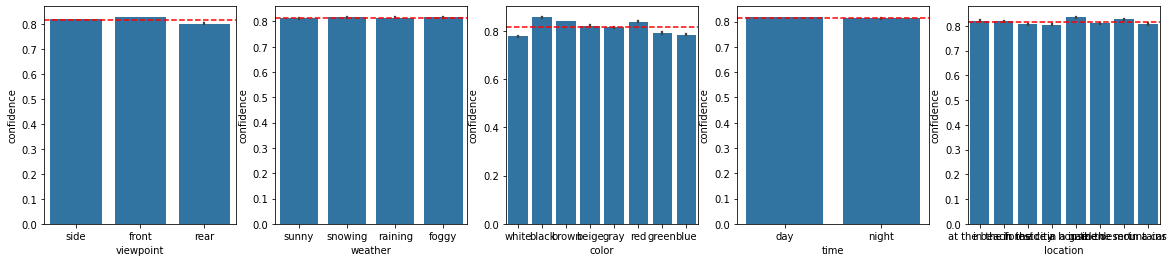

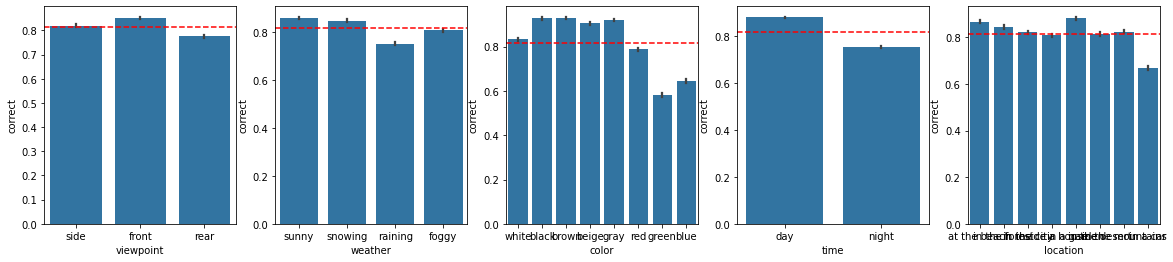

In [3]:
# plot some stats
avg_confid = df_res['confidence'].mean()
global_acc = df_res['correct'].mean()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, attribute in enumerate(attributes):
    sns.countplot(df_res, x=attribute, ax=axs.flatten()[i])

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, attribute in enumerate(attributes):
    sns.barplot(df_res, x=attribute, y='confidence', ax=axs.flatten()[i])
    axs.flatten()[i].axhline(y=avg_confid, color='r', linestyle='--', label='Average Confidence')

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, attribute in enumerate(attributes):
    sns.barplot(df_res, x=attribute, y='correct', ax=axs.flatten()[i])
    axs.flatten()[i].axhline(y=global_acc, color='r', linestyle='--', label='Global Accuracy')

In [4]:
df_train, df_test = train_test_split(df_res, test_size=0.2, random_state=0, shuffle=True)
df_calib, df_test = train_test_split(df_test, test_size=0.5, random_state=0, shuffle=True)
len(df_calib)

7680

In [5]:
auroc_subdomain = {}
for subdomain_attribute in attributes:
    df_test = semantic_binning(df_calib, df_test, [subdomain_attribute], ['dog', 'other'])
    auroc_subdomain[subdomain_attribute] = roc_auc_score(df_test['correct'], df_test['subdomain_score'])
sorted_attributes = sorted(auroc_subdomain, key=auroc_subdomain.get, reverse=True)

['viewpoint']
3 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.527 AUROC subdomains: 0.564
ECE baseline: 0.108 ECE: 0.005

['weather']
4 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.527 AUROC subdomains: 0.576
ECE baseline: 0.108 ECE: 0.009

['color']
8 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.527 AUROC subdomains: 0.718
ECE baseline: 0.108 ECE: 0.006

['time']
2 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.527 AUROC subdomains: 0.603
ECE baseline: 0.108 ECE: 0.006

['location']
8 subdomains
0 nan values (they appear because subdomains in test are not 

['color']
8 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.527 AUROC subdomains: 0.718
ECE baseline: 0.108 ECE: 0.006

['color', 'time']
16 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.527 AUROC subdomains: 0.749
ECE baseline: 0.108 ECE: 0.008

['color', 'time', 'location']
128 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.527 AUROC subdomains: 0.778
ECE baseline: 0.108 ECE: 0.027

['color', 'time', 'location', 'weather']
512 subdomains
12 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.527 AUROC subdomains: 0.777
ECE baseline: 0.108 ECE: 0.031

['color', 'time', 'location

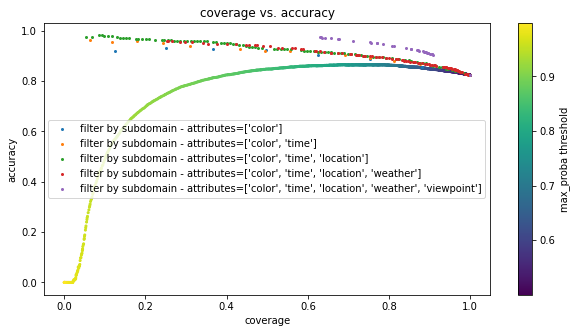

In [6]:
# baseline: max softmax
domain_cutoff_baseline = np.linspace(df_test['confidence'].min(), df_test['confidence'].max(), 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test.loc[idx_domain, 'correct'].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, s=4, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='max_proba threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')


for k in range(len(sorted_attributes)):
    attributes = sorted_attributes[:k+1]
    df_test = semantic_binning(df_calib, df_test, attributes, ['dog', 'other'], min_count=5)

    coverage = np.zeros(len(df_test['subdomain_score'].unique()))
    accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
    for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
        idx_domain = df_test['subdomain_score'] >= cut
        coverage[i] = idx_domain.mean()
        accuracy[i] = df_test[idx_domain]['correct'].mean()
    ax1.scatter(coverage, accuracy, s=4, label=f'filter by subdomain - attributes={attributes}')


plt.legend()
# plt.ylim((0.6, 1))